Grouped Bar Charts
==================
A grouped bar chart allows us to plot several columns for a single row in a DataFrame.
In this example we will first plot the demographics for specialized high schools
in our data set.

Then, we will show we we can use aggregates and melt to prepare our data to make
grouped bar charts at the district level. The general pattern for preparing the data
looks like this:

- group your data so that there is one row for each group of columns
- plot only the column for the group and the columns for the bars

In [1]:
import pandas as pd
import numpy as np

# graphs and viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from nycschools import schools, ui, exams, nysed


In [2]:
# # load the demographic data and merge it with the ELA data
# df = schools.load_school_demographics()

# # load the data from the csv file
# ela = exams.load_ela()
# #drop the rows with NaN (where the pop is too small to report)
# ela = ela[ela["mean_scale_score"].notnull()]
# ela = df.merge(ela, how="inner", on=["dbn", "ay"])
# ela = ela.query("ay == 2018 and category == 'All Students'")


Comparing specialized high schools
----------------------------------

Here we're going to plot the demographic data for Stuyvesant, Bronx Science, and Brooklyn Tech
high schools. These three schools' admissions criteria are set by NYS law to be based on scores on the SHSAT
exam. Other schools also use this exam for admissions, but NYC DOE can change the criteria for the
other "specialized" schools without seeking permission from the State.

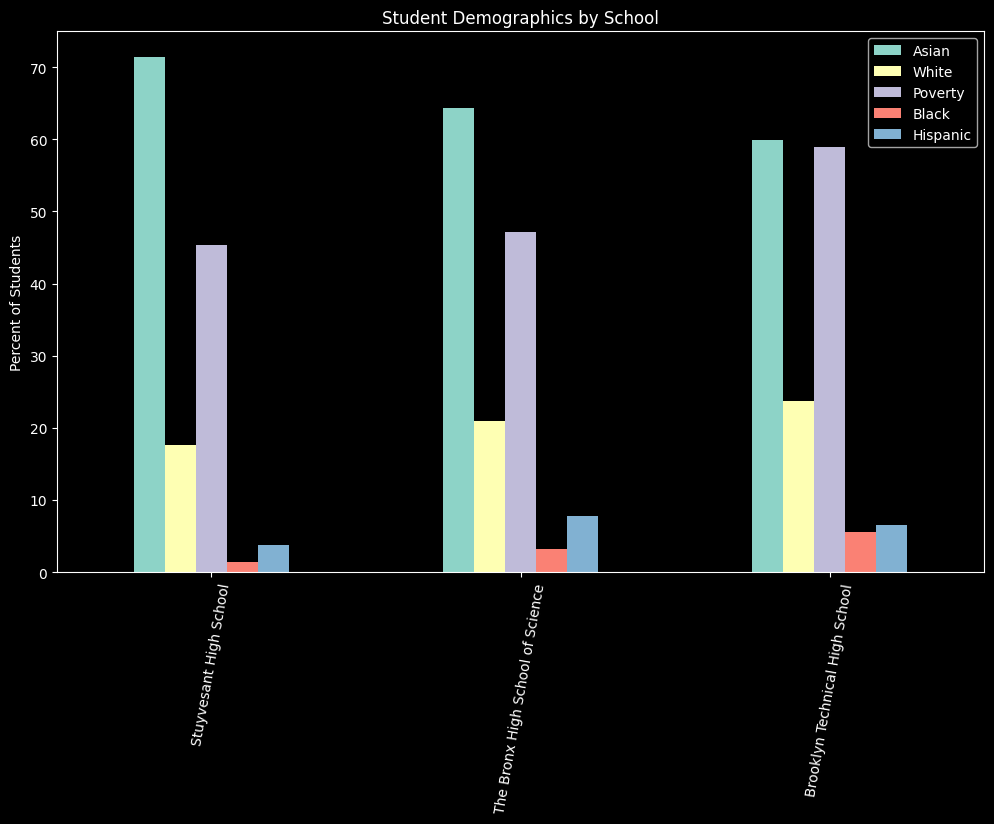

In [3]:
df = schools.load_school_demographics()
# find the schools by their dbn
dbn =["02M475", "13K430", "10X445"]
data = df[df["dbn"].isin(dbn)]
data = data[data["year"] == data.year.max()]

# get the columns we want and rename them for the graph
cols = ['school_name', 'asian_pct', 'white_pct', 'poverty_pct', 'black_pct', 'hispanic_pct']
pretty_cols = ['School', 'Asian', 'White', 'Poverty', 'Black', 'Hispanic']
data = data[cols]
data.columns = pretty_cols

# convert the real numbers to percentages
for col in pretty_cols[1:]:
    data[col] = data[col].apply(lambda x: x * 100)


# create the graph
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))
fig.tight_layout()
_ = data.plot(ax=ax, kind="bar", x="School", stacked=False, 
                rot=80, title="Student Demographics by School", xlabel="", ylabel="Percent of Students")



Pivot Data to Make Grouped Bars
-------------------------------
In the introduction we said that to easily make grouped bar charts, we want one column for each bar in our graph and one column for the grouping categories that label the x-axis. This is a challenge, though, when we have our data in a "long" data format. Long data contains one or more columns of categories that describe the data in other columns. For example, our `nysed` State test score data has a single column `mean_scale_score` which reports a schools average test score. Other columns _describe_ `mean_scale_score` for that row, specifically `exam` indicates if the score is an ELA or Math score, `category` offers demographic information about the sub-group of test takers (see below for categories tracked by NYSED), and `test_year` tells us the year the test was administered.


### Plotting ELA test results by year
In this example we will make a bar chart that demonstrates how ELA exam scores change (or didn't) over the years for which we have test result, showing results for four categories of students: All Students, ELL, Econ Disadv, and SWD. We will plot the value of mean scale score for each group and use mean scale score as the y-axis. Our x-axis will show the average score for each sub-group of students, grouped by test year.



In [4]:
# load the NYSED test data
scores = nysed.load_nyc_nysed()
# these are the categories of students we can choose to plot
scores.category.unique()


array(['All Students', 'Female', 'Male', 'Not SWD', 'SWD', 'Asian',
       'Black', 'Hispanic', 'White', 'Econ Disadv', 'Not Econ Disadv',
       'Current ELL', 'Never ELL', 'Not in Foster Care', 'Homeless',
       'Not Homeless', 'Not Migrant', 'Parent Not in Armed Forces',
       'Multiracial', 'American Indian or Alaska Native',
       'In Foster Care', 'Not English Language Learner',
       'Asian or Pacific Islander', 'Migrant',
       'Not Limited English Proficient', 'Limited English Proficient',
       'Parent in Armed Forces'], dtype=object)

In [5]:
# for this demo we will use the ELA scores and the students in our 4 categories
scores = scores[scores.exam == "ela"]
scores = scores[scores.category.isin(["All Students", "SWD", "Current ELL", 'Econ Disadv'])]

# group the data by year and category and get the mean score
scores = scores[['test_year', 'category', 'mean_scale_score']].groupby(['test_year', 'category']).mean()
#flatten the index after the groupby
scores = scores.reset_index()
scores


,test_year,category,mean_scale_score
0,2016,All Students,305.249764
1,2016,Econ Disadv,304.101053
2,2016,SWD,279.648133
3,2017,All Students,306.917031
4,2017,Current ELL,274.604554
5,2017,Econ Disadv,305.722363
6,2017,SWD,281.275277
7,2018,All Students,601.387562
8,2018,Current ELL,583.143293
9,2018,Econ Disadv,601.053047


### Pivot rows to columns
Now that we have the data that we want to plot, we need to pivot the rows into columns. After the pivot, each unique value in `category` will have its own row.

In [6]:

data = pd.pivot(scores, index=['test_year'], columns='category', values=['mean_scale_score'])

# flatten the index and rename the columns
data = data.reset_index()
data.columns = ["Test Year", "All Students", "ELL","Econ Disadv", "SWD"]
data

,Test Year,All Students,ELL,Econ Disadv,SWD
0,2016,305.249764,NaN,304.101053,279.648133
1,2017,306.917031,274.604554,305.722363,281.275277
2,2018,601.387562,583.143293,601.053047,587.745627
3,2019,600.554132,581.600260,600.231382,586.585979
4,2021,605.042509,585.739259,603.806349,591.540566


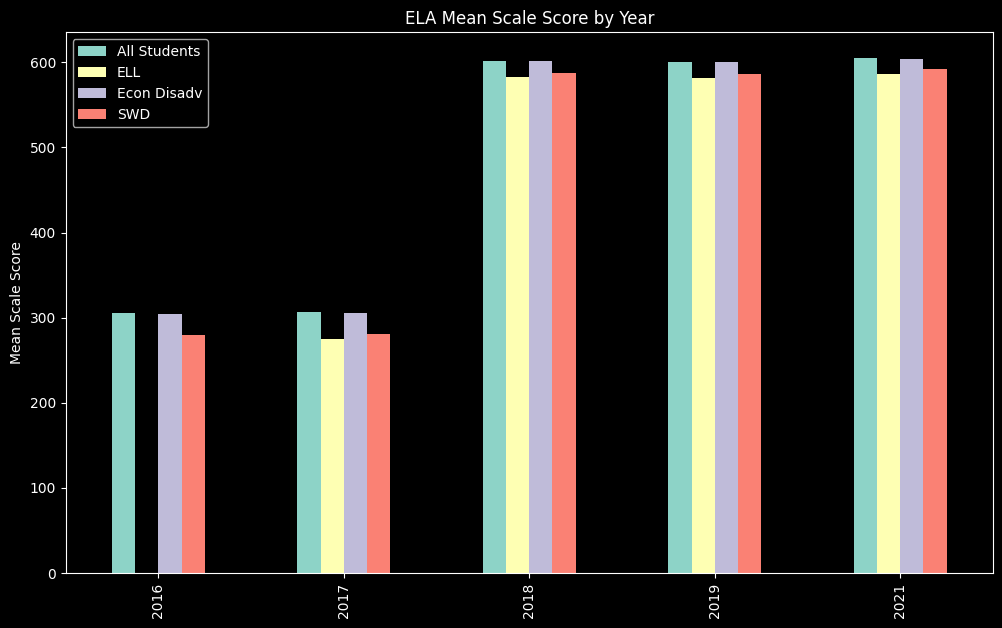

In [7]:
# now that our data is in the right format we can plot it
fig, ax = plt.subplots(figsize=(10, 6))
fig.tight_layout()
_ = data.plot(ax=ax, kind="bar", x="Test Year", stacked=False,
              title="ELA Mean Scale Score by Year", xlabel="", ylabel="Mean Scale Score")
